my reference for creating this recommender system model (thank you Heeral Dedhia!): [https://www.kaggle.com/heeraldedhia/movie-ratings-and-recommendation-using-knn](https://www.kaggle.com/heeraldedhia/movie-ratings-and-recommendation-using-knn "Movie Ratings and Recommendation using KNN")

# Constant Data

In [1]:
# import libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import operator
import random as rand
import numpy as np
import re
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# functions
def str_to_list(df, col):
    """
    Function to format datatypes in all columns of a 
    dataframe into a list

    Parameters:
    -----------
    df: The dataframe

    col: Columns that needs to be formatted
    """
    for c in col:
        if c:
            df[c] = df[c].apply(lambda x: x.split(
                ", ") if x is not np.nan and isinstance(x, str) else [x])

    return df


def remove_duplicates(x):
    """
    Function to remove duplicates in a list

    Parameters:
    -----------
    x: The list
    """
    # x = x.apply(lambda x: x.split(", "))
    x = x.explode()
    x = x.drop_duplicates()
    return set(x)


def binary(xList, yList):
    """
    One Hot Encoding
    """
    zList = []

    for x in xList:
        if yList != False and x in yList:
            zList.append(1)
        else:
            zList.append(0)

    return zList


def top_graph(df, name):

    lists = []
    for i in df:
        lists.extend(i)
    ax = pd.Series(lists).value_counts()[:25].sort_values(
        ascending=True).plot.barh(color=sns.color_palette('hls', 10))
    plt.title('Top ' + name)
    plt.show()


def time_to_numeric(x):
    h, m = x.split(":")
    return int(h) * 3600 + int(m) * 60


def min_max_normalize(val, min_val, max_val):
    for i, v in enumerate(val):
        val[i] = (v - min_val) / (max_val - min_val)
    return val

In [3]:
# import dataset
dir_path = os.getcwd()
xls = pd.ExcelFile(dir_path + "/datasets/raw_dataset.xlsx")
raw_museums = pd.read_excel(xls, "Sheet1")

# Exploration

In [4]:
# show first 5 rows of data
raw_museums.head(5)

,name,category,schedule_1,schedule_name_1,open_1,closed_1,schedule_2,schedule_name_2,open_2,closed_2,...,ticket_1,ticket_price_1,ticket_2,ticket_name_2,ticket_price_2,public_transportation,distance_to_museum,latitude,longitude,description
0,Art: 1 New Museum,Seni,"Selasa, Rabu, Kamis, Jumat, Sabtu",NaN,10:00,20:00,Minggu,NaN,10:00,16:00,...,"Wisatawan Mancanegara, Umum, Pelajar, Anak - Anak","125000, 100000, 75000, 0",NaN,NaN,NaN,"Bandara Halim Perdanakusuma, Stasiun Rajawali,...","26.9, 0.75, 3.2, 4.4, 5.7",-6.146950,106.840289,Art: 1 New Museum merupakan museum khusus yang...
1,Bayt Al-Qur’an dan Museum Istiqlal,Agama,"Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",NaN,08:30,15:00,NaN,NaN,NaN,NaN,...,Umum,0,NaN,NaN,NaN,"Bandara Soekarno - Hatta, Bandara Halim Perdan...","45, 10, 20.4, 22.6, 13, 4.3",-6.302798,106.887863,Museum Bayt Al-Qur’an dan Museum Istiqlal meru...
2,Galeri Foto Jurnalistik Antara,Sejarah,"Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",NaN,10:00,20:00,NaN,NaN,NaN,NaN,...,Umum,0,NaN,NaN,NaN,"Bandara Soekarno - Hatta, Bandara Halim Perdan...","29, 14, 1, 3, 3",-6.165897,106.833967,Gedung Galeri Foto Jurnalistik Antara merupaka...
3,Galeri Nasional Indonesia,Seni,"Selasa, Rabu, Kamis, Jumat",Pameran Tetap,09:00,16:00,"Senin, Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",Pameran Temporer,10:00,19:00,...,Umum,0,NaN,NaN,NaN,"Bandara Soekarno - Hatta, Bandara Halim Perdan...","28.6, 20.4, 22.7, 13.3",-6.178550,106.832772,Galeri Nasional Indonesia telah dirintis sejak...
4,Monumen Nasional,Sejarah,"Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",Pelataran Puncak Sesi 1,08:00,16:00,"Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",Pelataran Puncak Sesi 2,19:00,22:00,...,"Dewasa, Anak - Anak","20000, 10000","Dewasa, Anak - Anak",Pelataran Puncak,"7500, 3500","Stasiun Gambir, Stasiun Pasar Senen, Terminal ...","0.85, 3, 4, 4, 16, 30",-6.175394,106.827152,Monumen Nasional dibangun pada masa pemerintah...


In [5]:
# show columns
raw_museums.columns

Index(['name', 'category', 'schedule_1', 'schedule_name_1', 'open_1',
       'closed_1', 'schedule_2', 'schedule_name_2', 'open_2', 'closed_2',
       'schedule_3', 'schedule_name_3', 'open_3', 'closed_3', 'address',
       'city', 'phone_number', 'email', 'website', 'facebook', 'instagram',
       'twitter', 'ticket_1', 'ticket_price_1', 'ticket_2', 'ticket_name_2',
       'ticket_price_2', 'public_transportation', 'distance_to_museum',
       'latitude', 'longitude', 'description'],
      dtype='object')

In [6]:
# drop columns
raw_museums.drop(["schedule_name_1", "schedule_2", "schedule_name_2", "schedule_3", "schedule_name_3", "ticket_2", "ticket_name_2", "ticket_price_2", "address", "phone_number", "email", "website", "facebook", "instagram", "twitter", "latitude", "longitude", "open_2", "closed_2", "open_3", "closed_3", "distance_to_museum"], axis=1, inplace=True)
museums = raw_museums.copy()
museums.columns

Index(['name', 'category', 'schedule_1', 'open_1', 'closed_1', 'city',
       'ticket_1', 'ticket_price_1', 'public_transportation', 'description'],
      dtype='object')

## Convert time to numerical

In [7]:
museums["open_1"] = museums["open_1"].apply(lambda x: time_to_numeric(x) if x is not np.nan else np.nan)
museums["closed_1"] = museums["closed_1"].apply(lambda x: time_to_numeric(x) if x is not np.nan else np.nan)

## Data to List

In [8]:
museums = str_to_list(museums, ["category", "open_1", "closed_1", "city", "schedule_1", "ticket_1", "ticket_price_1", "public_transportation"])

In [9]:
museums.head(5)

,name,category,schedule_1,open_1,closed_1,city,ticket_1,ticket_price_1,public_transportation,description
0,Art: 1 New Museum,[Seni],"[Selasa, Rabu, Kamis, Jumat, Sabtu]",[36000.0],[72000.0],[Jakarta Pusat],"[Wisatawan Mancanegara, Umum, Pelajar, Anak - ...","[125000, 100000, 75000, 0]","[Bandara Halim Perdanakusuma, Stasiun Rajawali...",Art: 1 New Museum merupakan museum khusus yang...
1,Bayt Al-Qur’an dan Museum Istiqlal,[Agama],"[Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu]",[30600.0],[54000.0],[Jakarta Timur],[Umum],[0],"[Bandara Soekarno - Hatta, Bandara Halim Perda...",Museum Bayt Al-Qur’an dan Museum Istiqlal meru...
2,Galeri Foto Jurnalistik Antara,[Sejarah],"[Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu]",[36000.0],[72000.0],[Jakarta Pusat],[Umum],[0],"[Bandara Soekarno - Hatta, Bandara Halim Perda...",Gedung Galeri Foto Jurnalistik Antara merupaka...
3,Galeri Nasional Indonesia,[Seni],"[Selasa, Rabu, Kamis, Jumat]",[32400.0],[57600.0],[Jakarta Pusat],[Umum],[0],"[Bandara Soekarno - Hatta, Bandara Halim Perda...",Galeri Nasional Indonesia telah dirintis sejak...
4,Monumen Nasional,[Sejarah],"[Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu]",[28800.0],[57600.0],[Jakarta Pusat],"[Dewasa, Anak - Anak]","[20000, 10000]","[Stasiun Gambir, Stasiun Pasar Senen, Terminal...",Monumen Nasional dibangun pada masa pemerintah...


## Handle Categorical Data

### Working with Schedules

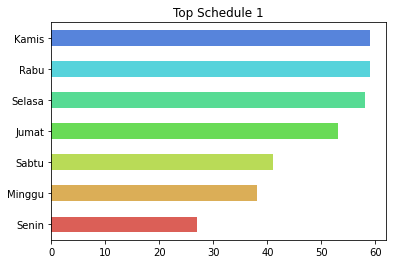

In [10]:
# Top schedule 1
schedule_1 = museums.filter(["schedule_1"], axis=1)
schedule_1.drop(schedule_1.index[schedule_1['schedule_1'] == np.nan], inplace=True)
top_graph(schedule_1["schedule_1"], "Schedule 1")

#### Generate sorted scheduleList

In [11]:
schedule_list = ["Senin", "Selasa", "Rabu", "Kamis", "Jumat", "Sabtu", "Minggu"]

#### One hot encoding for multiple labels for all schedules

In [12]:
museums["schedule_1_bin"] = museums["schedule_1"].apply(lambda x : binary(schedule_list, x))

In [13]:
museums["schedule_1_bin"].head()

0    [0, 1, 1, 1, 1, 1, 0]
1    [0, 1, 1, 1, 1, 1, 1]
2    [0, 1, 1, 1, 1, 1, 1]
3    [0, 1, 1, 1, 1, 0, 0]
4    [0, 1, 1, 1, 1, 1, 1]
Name: schedule_1_bin, dtype: object

### Working with ticket category

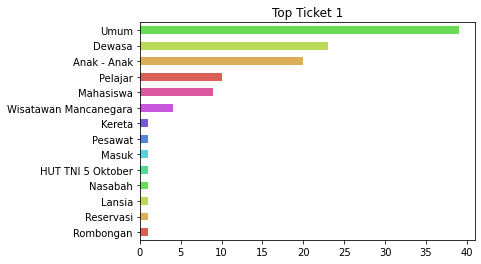

In [14]:
ticket_1 = museums.filter(["ticket_1"], axis=1)
ticket_1.drop(ticket_1.index[ticket_1['ticket_1'] == np.nan], inplace=True)
top_graph(ticket_1["ticket_1"], "Ticket 1")

#### Generate sorted ticket category

In [15]:
ticket_list = list(remove_duplicates(ticket_1["ticket_1"]))
ticket_list.sort()
ticket_list

['Anak - Anak',
 'Dewasa',
 'HUT TNI 5 Oktober',
 'Kereta',
 'Lansia',
 'Mahasiswa',
 'Masuk',
 'Nasabah',
 'Pelajar',
 'Pesawat',
 'Reservasi',
 'Rombongan',
 'Umum',
 'Wisatawan Mancanegara']

#### One hot encoding for multiple labels for all ticket category

In [16]:
museums["ticket_1_bin"] = museums["ticket_1"].apply(lambda x : binary(ticket_list, x))

In [17]:
museums["ticket_1_bin"].head()

0    [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
4    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: ticket_1_bin, dtype: object

### Working with public transportation

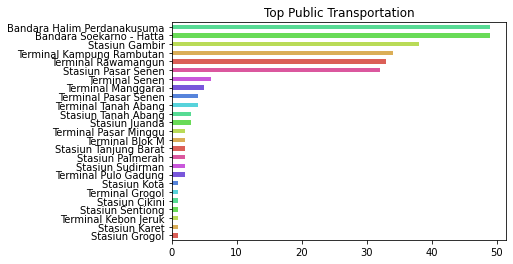

In [18]:
public_transportation = museums.filter(["public_transportation"], axis=1)
public_transportation.drop(public_transportation.index[public_transportation['public_transportation'] == np.nan], inplace=True)
top_graph(public_transportation["public_transportation"], "Public Transportation")

#### Generate sorted public transportation

In [19]:
transportation_list = list(remove_duplicates(public_transportation["public_transportation"]))
transportation_list.sort()
transportation_list

['Bandara Halim Perdanakusuma',
 'Bandara Soekarno - Hatta',
 'Stasiun Cawang',
 'Stasiun Cikini',
 'Stasiun Gambir',
 'Stasiun Gondangdia',
 'Stasiun Grogol',
 'Stasiun Jakarta Utara',
 'Stasiun Juanda',
 'Stasiun Karet',
 'Stasiun Kemayoran',
 'Stasiun Kota',
 'Stasiun Manggarai',
 'Stasiun Palmerah',
 'Stasiun Pasar Minggu',
 'Stasiun Pasar Senen',
 'Stasiun Rajawali',
 'Stasiun Sawah Besar',
 'Stasiun Senen',
 'Stasiun Sentiong',
 'Stasiun Sudirman',
 'Stasiun Tanah Abang',
 'Stasiun Tanjung Barat',
 'Stasiun Tebet',
 'Terminal Blok M',
 'Terminal Grogol',
 'Terminal Kalideres',
 'Terminal Kampung Melayu',
 'Terminal Kampung Rambutan',
 'Terminal Kebon Jeruk',
 'Terminal Manggarai',
 'Terminal Pasar Minggu',
 'Terminal Pasar Senen',
 'Terminal Pulo Gadung',
 'Terminal Rawamangun',
 'Terminal Senen',
 'Terminal Tanah Abang']

#### One hot encoding for multiple labels for public transportation

In [20]:
museums["public_transportation_bin"] = museums["public_transportation"].apply(lambda x : binary(transportation_list, x))

In [21]:
museums["public_transportation_bin"].head()

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
1    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: public_transportation_bin, dtype: object

### Working with category

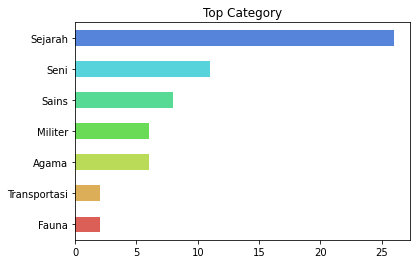

In [22]:
category = museums.filter(["category"], axis=1)
category.drop(category.index[category['category'] == False], inplace=True)
top_graph(category["category"], "Category")

#### Generate sorted category

In [23]:
category_list = list(remove_duplicates(category["category"]))
category_list.sort()
category_list

['Agama', 'Fauna', 'Militer', 'Sains', 'Sejarah', 'Seni', 'Transportasi']

#### One hot encoding for multiple labels for category

In [24]:
museums["category_bin"] = museums["category"].apply(lambda x : binary(category_list, x))

In [25]:
museums["category_bin"].head()

0    [0, 0, 0, 0, 0, 1, 0]
1    [1, 0, 0, 0, 0, 0, 0]
2    [0, 0, 0, 0, 1, 0, 0]
3    [0, 0, 0, 0, 0, 1, 0]
4    [0, 0, 0, 0, 1, 0, 0]
Name: category_bin, dtype: object

### Working with city

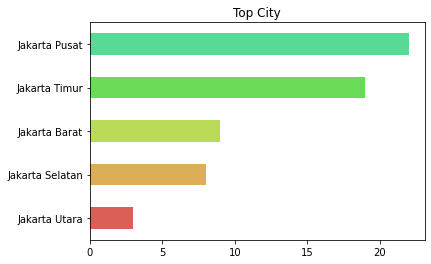

In [26]:
city = museums.filter(["city"], axis=1)
city.drop(city.index[city['city'] == np.nan], inplace=True)
top_graph(city["city"], "City")

#### Generate sorted city

In [27]:
city_list = list(remove_duplicates(city["city"]))
city_list.sort()
city_list

['Jakarta Barat',
 'Jakarta Pusat',
 'Jakarta Selatan',
 'Jakarta Timur',
 'Jakarta Utara']

#### One hot encoding for multiple labels for city

In [28]:
museums["city_bin"] = museums["city"].apply(lambda x : binary(city_list, x))

In [29]:
museums["city_bin"].head()

0    [0, 1, 0, 0, 0]
1    [0, 0, 0, 1, 0]
2    [0, 1, 0, 0, 0]
3    [0, 1, 0, 0, 0]
4    [0, 1, 0, 0, 0]
Name: city_bin, dtype: object

## Handle Numerical Data

### Working with Open & Closed Time

In [30]:
open_time = museums.filter(["open_1"], axis=1)
open_time.drop(index=15, inplace=True)
open_list = list(remove_duplicates(open_time["open_1"]))
open_list.sort()
open_min, open_max = open_list[0], open_list[-1]

In [31]:
closed_time = museums.filter(["closed_1"], axis=1)
closed_time.drop(index=15, inplace=True)
closed_list = list(remove_duplicates(closed_time["closed_1"]))
closed_list.sort()
closed_min, closed_max = closed_list[0], closed_list[-1]

In [32]:
museums["open_1"] = open_time["open_1"].apply(lambda x: min_max_normalize(x, open_min, open_max))
museums["closed_1"] = closed_time["closed_1"].apply(lambda x: min_max_normalize(x, closed_min, closed_max))
museums["open_1"].iloc[15] = [0.0]
museums["closed_1"].iloc[15] = [0.0]

### Working with Ticket Price

In [33]:
ticket_price = museums.filter(["ticket_price_1"], axis=1)
ticket_price.drop(ticket_price.index[ticket_price['ticket_price_1'] == np.nan], inplace=True)
ticket_price["ticket_price_1"] = ticket_price["ticket_price_1"].apply(lambda x: list(map(int, x)))
ticket_price_list = list(remove_duplicates(ticket_price["ticket_price_1"]))
ticket_price_list.sort()
ticket_price_min, ticket_price_max = ticket_price_list[0], ticket_price_list[-1]

In [34]:
museums["ticket_price_1"] = ticket_price["ticket_price_1"].apply(lambda x: min_max_normalize(x, ticket_price_min, ticket_price_max))

# TFIDF

In [35]:
df = museums[["name", "description"]].copy()
df

,name,description
0,Art: 1 New Museum,Art: 1 New Museum merupakan museum khusus yang...
1,Bayt Al-Qur’an dan Museum Istiqlal,Museum Bayt Al-Qur’an dan Museum Istiqlal meru...
2,Galeri Foto Jurnalistik Antara,Gedung Galeri Foto Jurnalistik Antara merupaka...
3,Galeri Nasional Indonesia,Galeri Nasional Indonesia telah dirintis sejak...
4,Monumen Nasional,Monumen Nasional dibangun pada masa pemerintah...
...,...,...
56,Museum Timor Timur,Museum Timor Timur merupakan museum khusus yan...
57,Museum Tragedi 12 Mei ’98 Universitas Trisakti,Museum Tragedi 12 Mei ‘98 Universitas Trisakti...
58,Museum Transportasi,Museum Transportasi merupakan museum khusus ya...
59,Museum Wayang,Museum Wayang merupakan museum khusus yang pad...


## Preprocessing

In [36]:
%%time
df["description"] = df["description"].apply(lambda x: str(x).replace("\n", " "))
# Converting all words to lower case and removing punctuation
df['description'] = [re.sub(r'\d+\S*', '',
                  row.lower().replace('.', ' ').replace('_', '').replace('/', ''))
                  for row in df['description']]

df['description'] = [re.sub(r'[^\w\s]', '', row)
                  for row in df['description']]

# Removing numbers
df['description'] = [re.sub(r'\d+', '', row) for row in df['description']]

CPU times: user 2.18 ms, sys: 1.15 ms, total: 3.33 ms
Wall time: 3.14 ms


In [37]:
%%time
nltk.download("stopwords")

# Tokenizing comments and putting them into a new column
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')  # by blank space
df['tokens'] = df['description'].apply(tokenizer.tokenize)

CPU times: user 11.2 ms, sys: 1.55 ms, total: 12.7 ms
Wall time: 169 ms


[nltk_data] Downloading package stopwords to /home/reykim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
%%time
# Removing Stopwords & Punctuation

filtered_words = []
for row in df['tokens']:
    filtered_words.append([
        word.lower() for word in row
        if word.lower() not in nltk.corpus.stopwords.words('indonesian')
    ])

df['tokens'] = filtered_words

CPU times: user 842 ms, sys: 46.2 ms, total: 888 ms
Wall time: 888 ms


In [39]:
%%time
# Setting the Lemmatization object
nltk.download("wordnet")
lmtzr = nltk.stem.wordnet.WordNetLemmatizer()

# Looping through the words and appending the lemmatized version to a list
stemmed_words = []
for row in df['tokens']:
    stemmed_words.append([
        # Verbs
        lmtzr.lemmatize(  
            # Adjectives
            lmtzr.lemmatize(  
                # Nouns
                lmtzr.lemmatize(word.lower()), 'a'), 'v')
        for word in row
        if word.lower() not in nltk.corpus.stopwords.words('indonesian')])

# Adding the list as a column in the data frame
df['tokens'] = stemmed_words

[nltk_data] Downloading package wordnet to /home/reykim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


CPU times: user 1.41 s, sys: 84.1 ms, total: 1.49 s
Wall time: 1.49 s


In [40]:
allWords = []
for row in stemmed_words:
    for word in row:
        allWords.append(str(word))
            
uniqueWords = np.unique(allWords)

In [41]:
stemmed_sentences = []

# Spacing out the words in the lyrics for each song
for row in df['tokens']:
    stemmed_string = ''
    for word in row:
        stemmed_string = stemmed_string + ' ' + word
    stemmed_sentences.append(stemmed_string)
    
df['tokens'] = stemmed_sentences

In [42]:
# Creating the sklearn object
tfidf = TfidfVectorizer(smooth_idf=False)

# Transforming our 'tokens' column into a TF-IDF matrix and then a data frame
tfidf_df = pd.DataFrame(tfidf.fit_transform(df['tokens']).toarray(), 
                        columns=tfidf.get_feature_names_out())

In [43]:
# Removing sparse columns
tfidf_df = tfidf_df[tfidf_df.columns[tfidf_df.sum() > 1]]

# Removing any remaining digits
tfidf_df = tfidf_df.filter(regex=r'^((?!\d).)*$')

## Cosine Similarity

In [44]:
cosine = cosine_similarity(tfidf_df)
similarities = {}
for i in range(len(cosine)):
    indices = cosine[i].argsort()[:-62:-1]
    similarities[i] = [{"id": x, "sim": cosine[i][x]} for x in indices][1:]

In [45]:
import pickle
with open(dir_path + '/datasets/similarities.json', 'wb') as fp:
    pickle.dump(similarities, fp)

# Experiment

In [46]:
# drop unused columns
new_museums = museums.copy()
new_museums.drop(["category", "city", "schedule_1", "ticket_1", "public_transportation", "description"], axis=1, inplace=True)
new_museums.head()

,name,open_1,closed_1,ticket_price_1,schedule_1_bin,ticket_1_bin,public_transportation_bin,category_bin,city_bin
0,Art: 1 New Museum,[0.6],[1.0],"[0.6756756756756757, 0.5405405405405406, 0.405...","[0, 1, 1, 1, 1, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0]"
1,Bayt Al-Qur’an dan Museum Istiqlal,[0.3],[0.2857142857142857],[0.0],"[0, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0]"
2,Galeri Foto Jurnalistik Antara,[0.6],[1.0],[0.0],"[0, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0]","[0, 1, 0, 0, 0]"
3,Galeri Nasional Indonesia,[0.4],[0.42857142857142855],[0.0],"[0, 1, 1, 1, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0]"
4,Monumen Nasional,[0.2],[0.42857142857142855],"[0.10810810810810811, 0.05405405405405406]","[0, 1, 1, 1, 1, 1, 1]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0]","[0, 1, 0, 0, 0]"


In [47]:
new_museums.to_csv(dir_path + "/datasets/museums_binary.csv", index=False)

### Recommender System

#### Cosine Distance Function

In [49]:
# for key in similarities:
#     for idx, val in enumerate(similarities[key]):
#         similarities[key][idx]["dist"] = cosine_distance(val["dist"], int(key), val["id"])
#     similarities[key].sort(key=lambda x: x["dist"])

In [50]:
with open(dir_path + '/datasets/similarities.json', 'rb') as fp:
    data = pickle.load(fp)

In [65]:
def convert_length(point1, point2):
    if len(point1) > len(point2):
        point2 = point2[:len(point1)] + [0]*(len(point1) - len(point2))
    else:
        point1 = point1[:len(point2)] + [0]*(len(point2) - len(point1))

    return point1, point2

def cosine_distance(museum_id_1, museum_id_2):
    """
    Search distance with cosine distance
    """
    a = new_museums.iloc[museum_id_1]
    b = new_museums.iloc[museum_id_2]

    for val in data[museum_id_1]:
        if val["id"] == museum_id_2:
            distance = 1 - val["sim"]
            break

    def cosine(col, point1, point2):
        point1 = list(map(float, point1))
        point2 = list(map(float, point2))
        
        if col == "ticket_price_1":
            point1, point2 = convert_length(point1, point2)
    
        w = 0
        x = 0
        y = 0
        z = 0
        for i in range(len(point1)):
            x += (point1[i] * point2[i])
            y += math.pow(point1[i], 2)
            z += math.pow(point2[i], 2)
        w = (math.sqrt(y) * math.sqrt(z))
        return 1 - (x / w) if w != 0 else 0

    for col, val in a.iteritems():
        if col != "name":
            distance += cosine(col, a[col], b[col])

    return distance


#### KNN

In [91]:
def recommender(name, distance_fn):
    pred_museum = new_museums.loc[new_museums['name'] == name]

    def knn(base, K):
        distances = []

        for idx, museum in new_museums.iterrows():
            if idx != base.index[0]:
                dist = distance_fn(base.index[0], idx)
                distances.append((idx, dist))

        distances.sort(key=operator.itemgetter(1))
        neighbors = distances[:K]

        return neighbors

    K = 15
    neighbors = knn(pred_museum, K)

    recommend = []

    for neighbor in neighbors:
        recommend.append([new_museums.iloc[neighbor[0]][0],
                          str(raw_museums.iloc[neighbor[0]][1]),
                          str(raw_museums.iloc[neighbor[0]][2]),
                          str(raw_museums.iloc[neighbor[0]][3]),
                          str(raw_museums.iloc[neighbor[0]][4]),
                          str(raw_museums.iloc[neighbor[0]][5]),
                          str(raw_museums.iloc[neighbor[0]][6]),
                          str(raw_museums.iloc[neighbor[0]][7]),
                          str(raw_museums.iloc[neighbor[0]][8]),
                          neighbor[1]])

    col = list(museums.columns[:9])
    col.append("distance")
    df = pd.DataFrame(data=recommend, columns=col)
    # .sort_values(by=["name"])
    return df
    # return recommend


### Experiment 1

In [99]:
query_1 = raw_museums["name"].iloc[rand.randint(0, 60)]
raw_museums.loc[raw_museums['name'] == query_1]

,name,category,schedule_1,open_1,closed_1,city,ticket_1,ticket_price_1,public_transportation,description
20,Museum Fauna Indonesia “Komodo” dan Taman Rept...,Fauna,"Senin, Selasa, Rabu, Kamis, Jumat",08:30,16:00,Jakarta Timur,Umum,25000,"Bandara Soekarno - Hatta, Bandara Halim Perdan...",Museum Fauna Indonesia “Komodo” dan Taman Rept...


In [100]:
# # using cosine distance
recommender(query_1, cosine_distance)

,name,category,schedule_1,open_1,closed_1,city,ticket_1,ticket_price_1,public_transportation,distance
0,Museum Serangga,Fauna,"Senin, Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",09:00,16:00,Jakarta Timur,Umum,25000,"Bandara Soekarno - Hatta, Bandara Halim Perdan...",0.493824
1,Museum Listrik dan Energi Baru,Sains,"Senin, Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",08:00,16:00,Jakarta Timur,Umum,10000,"Bandara Soekarno - Hatta, Bandara Halim Perdan...",1.497382
2,Museum Indonesia,Sejarah,"Senin, Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",09:00,16:00,Jakarta Timur,Umum,15000,"Bandara Soekarno - Hatta, Bandara Halim Perdan...",1.518634
3,Museum Timor Timur,Sejarah,"Senin, Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",08:30,16:00,Jakarta Timur,Umum,5000,"Bandara Halim Perdanakusuma, Stasiun Gambir, S...",1.564155
4,Museum Prangko,Sejarah,"Senin, Selasa, Rabu, Kamis, Jumat",08:00,16:00,Jakarta Timur,Umum,5000,"Bandara Soekarno - Hatta, Bandara Halim Perdan...",1.578962
5,Museum Graha Widya Patra (Minyak dan Gas Bumi),Sains,"Senin, Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",08:00,16:00,Jakarta Timur,Umum,15000,"Bandara Soekarno - Hatta, Bandara Halim Perdan...",1.649541
6,Pusat Peragaan IPTEK,Sains,"Senin, Selasa, Rabu, Kamis",08:30,16:00,Jakarta Timur,Umum,16500,"Bandara Soekarno - Hatta, Bandara Halim Perdan...",1.686646
7,Museum Pusaka,Sejarah,"Senin, Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",09:00,16:00,Jakarta Timur,Umum,10000,"Bandara Soekarno - Hatta, Bandara Halim Perdan...",1.693336
8,Museum Asmat,Sejarah,"Senin, Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",08:30,16:00,Jakarta Timur,Umum,10000,"Bandara Soekarno - Hatta, Bandara Halim Perdan...",1.789173
9,Museum Penerangan,Sains,"Senin, Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu",08:00,16:00,Jakarta Timur,Umum,0,"Bandara Soekarno - Hatta, Bandara Halim Perdan...",1.793520
